# Classificadores binários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import warnings
import collections as cll
from keras.utils import np_utils
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Correta')
    plt.xlabel('Classe Prevista')
    
    return fig

In [3]:
df = pd.read_csv('especialista.csv')

In [4]:
df.describe()

,variacao_lon,variacao_lat,variacao_odometro,variacao_velocidade,tensao_bateria_min,tensao_bateria_max,tensao_bateria_min_igon,tensao_bateria_max_igon,tensao_bateria_min_igoff,tensao_bateria_max_igoff,variacao_tensao_bateria,bateria_RMS,variacao_ignicao,maior_pulo_negativo_idx,maior_pulo_positivo_idx,numero_pulos_idx,quantidade_pontos_gps_valido,quantidade_pontos_gps_invalido,possui_falhas,numero_saltos_gps
count,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000,12586.000000
mean,0.847529,0.847211,0.712697,0.835134,0.375385,-0.284845,0.365945,0.065230,0.277914,-0.182792,-0.263626,0.146969,0.738360,-1990.098999,0.001726,0.006766,8.442915,0.322636,0.594311,0.796997
std,0.359491,0.359798,0.452522,0.371074,0.853724,0.464951,1.047186,0.416305,1.159674,0.597470,0.511891,1.015159,0.439545,9420.259365,0.050113,0.075267,20.669104,0.881408,0.491044,2.513852
min,0.000000,0.000000,0.000000,0.000000,-9.356725,-1.752266,-12.444444,-0.477742,-9.062003,-1.600000,-0.987564,-2.781875,0.000000,-65535.000000,0.000000,0.000000,0.000000,-0.435819,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,-0.879758,0.000000,-0.477742,-0.397456,-0.666667,-0.854792,-0.444040,0.000000,0.000000,0.000000,0.000000,0.000000,-0.301307,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.003548,0.000000,0.000000,0.000000,-0.000370,1.000000,0.000000,0.000000,0.000000,0.000000,-0.004612,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000835,0.120846,1.000000,0.522258,0.602544,0.333333,0.146306,0.556198,1.000000,0.000000,0.000000,0.000000,1.066667,0.694850,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.589808,0.120846,3.444444,0.522258,3.577107,0.466667,3.108998,11.017201,1.000000,0.000000,4.000000,4.000000,214.666667,10.471176,1.000000,12.000000


In [5]:
cll.Counter(df['falhas'])

Counter({'[2]': 2170, '[3]': 1573, '[outras]': 2035, '[]': 5106, '[4]': 1702})

## Definindo conjuntos de treinamento e teste

In [6]:
df.columns

Index(['variacao_lon', 'variacao_lat', 'variacao_odometro',
       'variacao_velocidade', 'tensao_bateria_min', 'tensao_bateria_max',
       'tensao_bateria_min_igon', 'tensao_bateria_max_igon',
       'tensao_bateria_min_igoff', 'tensao_bateria_max_igoff',
       'variacao_tensao_bateria', 'bateria_RMS', 'variacao_ignicao',
       'maior_pulo_negativo_idx', 'maior_pulo_positivo_idx',
       'numero_pulos_idx', 'quantidade_pontos_gps_valido',
       'quantidade_pontos_gps_invalido', 'falhas', 'possui_falhas',
       'numero_saltos_gps'],
      dtype='object')

In [7]:
#X = df.drop(['serial', 'data', 'hora_ultimo_ponto', 'hora_primeiro_ponto', 'possui_falhas'], axis = 1)
X = df.drop(['falhas', 'possui_falhas'], axis = 1)
features = X.columns
y = df['falhas']
classes = ['[2]','[3]', '[4]', 'Flawless', 'Others']

# Undersampling

In [8]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Oversampling

In [9]:
sm = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [10]:
X_train.shape

(6410, 19)

In [11]:
X_test.shape

(1573, 19)

## Random Forest

In [12]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)

CPU times: user 545 ms, sys: 3.75 ms, total: 549 ms
Wall time: 548 ms


              precision    recall  f1-score   support

         [2]     1.0000    0.9971    0.9985       341
         [3]     0.9908    1.0000    0.9954       322
         [4]     0.9966    0.9966    0.9966       291
          []     1.0000    0.9868    0.9933       302
    [outras]     0.9875    0.9937    0.9906       317

   micro avg     0.9949    0.9949    0.9949      1573
   macro avg     0.9950    0.9948    0.9949      1573
weighted avg     0.9949    0.9949    0.9949      1573

CPU times: user 107 ms, sys: 162 µs, total: 107 ms
Wall time: 106 ms


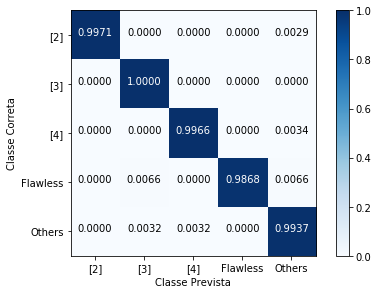

In [13]:
%%time
predictionsRF = rfc.predict(X_test)
print(classification_report(y_test,predictionsRF,digits=4))
cm = confusion_matrix(y_test,predictionsRF)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

Text(0.5, 0, 'Importânca relativa')

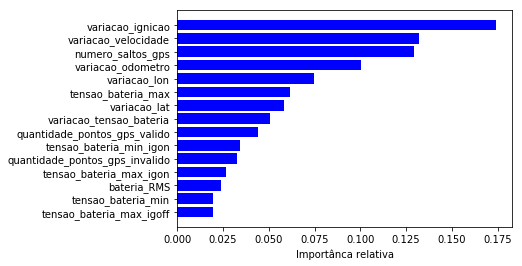

In [14]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
# Print the top 15 feature ranking
quant = 15
#plt.title('Importância dos atributos')
plt.barh(range(quant), importances[indices][-quant:], color='b', align='center')
plt.yticks(range(quant), [features[i] for i in indices[-quant:]])
plt.xlabel('Importânca relativa')

              precision    recall  f1-score   support

         [2]     1.0000    1.0000    1.0000      1282
         [3]     1.0000    1.0000    1.0000      1282
         [4]     1.0000    1.0000    1.0000      1282
          []     1.0000    1.0000    1.0000      1282
    [outras]     1.0000    1.0000    1.0000      1282

   micro avg     1.0000    1.0000    1.0000      6410
   macro avg     1.0000    1.0000    1.0000      6410
weighted avg     1.0000    1.0000    1.0000      6410



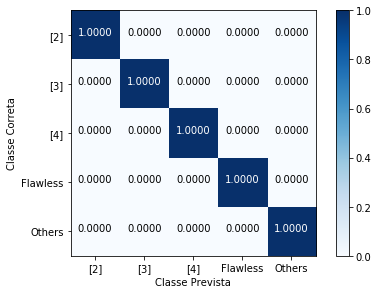

In [15]:
pred_underfitting = rfc.predict(X_train)
print(classification_report(y_train,pred_underfitting,digits=4))
cm = confusion_matrix(y_train,pred_underfitting)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

## Naive Bayes

In [16]:
%%time
bnb = BernoulliNB()
bnb.fit(X_train,y_train)

CPU times: user 22.3 ms, sys: 139 µs, total: 22.5 ms
Wall time: 98.9 ms


              precision    recall  f1-score   support

         [2]     0.9467    0.9384    0.9426       341
         [3]     0.6270    0.7360    0.6771       322
         [4]     0.8339    0.7766    0.8043       291
          []     0.8449    0.8477    0.8463       302
    [outras]     0.7032    0.6278    0.6633       317

   micro avg     0.7870    0.7870    0.7870      1573
   macro avg     0.7911    0.7853    0.7867      1573
weighted avg     0.7918    0.7870    0.7879      1573

CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 158 ms


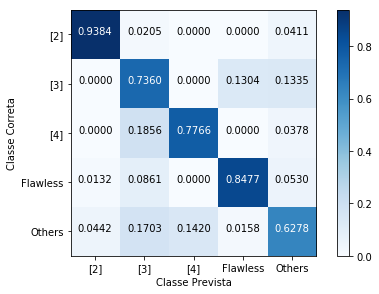

In [17]:
%%time
predictionsNB = bnb.predict(X_test)
print(classification_report(y_test,predictionsNB,digits=4))
cm = confusion_matrix(y_test,predictionsNB)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

              precision    recall  f1-score   support

         [2]     0.9162    0.9555    0.9355      1282
         [3]     0.6264    0.7637    0.6882      1282
         [4]     0.8207    0.7925    0.8063      1282
          []     0.8659    0.8510    0.8584      1282
    [outras]     0.7372    0.5819    0.6504      1282

   micro avg     0.7889    0.7889    0.7889      6410
   macro avg     0.7933    0.7889    0.7878      6410
weighted avg     0.7933    0.7889    0.7878      6410

CPU times: user 493 ms, sys: 7.42 ms, total: 500 ms
Wall time: 128 ms


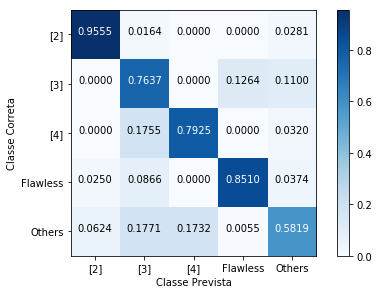

In [18]:
%%time
predictionsNB = bnb.predict(X_train)
print(classification_report(y_train,predictionsNB,digits=4))
cm = confusion_matrix(y_train,predictionsNB)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

## SVM

In [19]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [10, 1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)

CPU times: user 1min 43s, sys: 483 ms, total: 1min 43s
Wall time: 1min 43s


              precision    recall  f1-score   support

         [2]     0.9827    1.0000    0.9913       341
         [3]     0.9692    0.9783    0.9737       322
         [4]     0.9965    0.9759    0.9861       291
          []     0.9484    0.9735    0.9608       302
    [outras]     0.9804    0.9464    0.9631       317

   micro avg     0.9752    0.9752    0.9752      1573
   macro avg     0.9754    0.9748    0.9750      1573
weighted avg     0.9754    0.9752    0.9752      1573

CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 158 ms


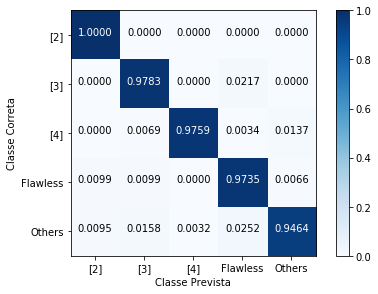

In [20]:
%%time
predictionsSVM = grid.predict(X_test)
print(classification_report(y_test,predictionsSVM,digits=4))
cm = confusion_matrix(y_test,predictionsSVM)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

In [21]:
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

# MLP

In [22]:
%%time
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 5), random_state=1,early_stopping=True)
mlp.fit(X_train, y_train)

CPU times: user 3.28 s, sys: 3.77 ms, total: 3.28 s
Wall time: 1.03 s


              precision    recall  f1-score   support

         [2]     0.9797    0.9883    0.9839       341
         [3]     0.9369    0.9224    0.9296       322
         [4]     0.8862    0.9897    0.9351       291
          []     0.9083    0.9834    0.9444       302
    [outras]     0.9846    0.8076    0.8873       317

   micro avg     0.9377    0.9377    0.9377      1573
   macro avg     0.9391    0.9383    0.9361      1573
weighted avg     0.9409    0.9377    0.9367      1573

CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 91.2 ms


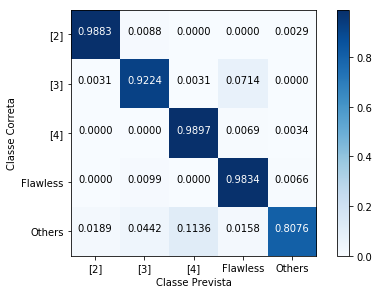

In [23]:
%%time
predictionsMLP = mlp.predict(X_test)
print(classification_report(y_test,predictionsMLP,digits=4))
cm = confusion_matrix(y_test,predictionsMLP)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')

              precision    recall  f1-score   support

         [2]     0.9883    0.9875    0.9879      1282
         [3]     0.9502    0.9220    0.9359      1282
         [4]     0.9079    0.9914    0.9478      1282
          []     0.9116    0.9891    0.9487      1282
    [outras]     0.9872    0.8424    0.9091      1282

   micro avg     0.9465    0.9465    0.9465      6410
   macro avg     0.9490    0.9465    0.9459      6410
weighted avg     0.9490    0.9465    0.9459      6410



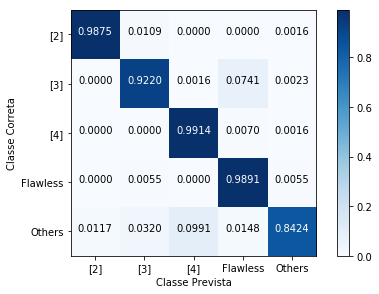

In [24]:
predictionsMLP = mlp.predict(X_train)
print(classification_report(y_train,predictionsMLP,digits=4))
cm = confusion_matrix(y_train,predictionsMLP)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')